### Описание задачи

В этом конкурсе разработаем алгоритмы для классификации генетических мутаций на основе клинических данных (текст).  
  
Генетическая мутация может быть отнесена к девяти различным классам.  
  
Это нетривиальная задача, поскольку интерпретация клинических данных очень сложна даже для специалистов-людей. Таким образом, моделирование клинических данных (текста) будет иметь решающее значение для успеха вашего подхода.  
  
Как обучающие, так и тестовые наборы данных предоставляются в виде двух разных файлов. Один (обучение/тест_варианты) предоставляет информацию о генетических мутациях, тогда как другой (обучение/тест_текст) предоставляет клинические данные (текст), которые наши специалисты-люди использовали для классификации генетических мутаций. Оба связаны через поле ID.  
  
Поэтому генетическая мутация (строка) с ID=15 в файле training_variants была классифицирована с использованием клинических данных (текста) из строки с ID=15 в файле training_text.  
  
<b>Описания файлов:</b>  
* <b>training_variants</b>  — разделенный запятыми файл, содержащий описание генетических мутаций, используемых для обучения. Поля: идентификатор (идентификатор строки, используемой для связи мутации с клиническими данными), ген (ген, в котором находится эта генетическая мутация), вариация (изменение аминокислоты для этой мутации), класс (1-9 класс, в котором находится эта мутация). генетическая мутация была классифицирована на)
* <b>training_text</b>  — файл с разделителями в виде двойной вертикальной черты (||), который содержит клинические данные (текст), используемые для классификации генетических мутаций. Поля: ID (идентификатор строки, используемой для связи клинических данных с генетической мутацией), Текст (клинические данные, используемые для классификации генетической мутации).
* <b>test_variants</b>  — разделенный запятыми файл, содержащий описание генетических мутаций, используемых для обучения. Поля: ID (идентификатор строки, используемой для связи мутации с клиническими данными), Gene (ген, в котором расположена эта генетическая мутация), Variation (изменение аминокислоты для этой мутации).
* <b>test_text</b> — файл с разделителями в виде двойной вертикальной черты (||), который содержит клинические доказательства (текст), используемые для классификации генетических мутаций. Поля: ID (идентификатор строки, используемой для связи клинических данных с генетической мутацией), Текст (клинические данные, используемые для классификации генетической мутации).
* <b>submitSample</b>  — образец файла отправки в правильном формате

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
from collections import Counter
import sklearn
from nltk.stem.porter import PorterStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import GridSearchCV, train_test_split, ShuffleSplit, KFold
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, log_loss
import pickle
import py7zr

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\belov\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 1. Анализ данных

#### 1.1. Загрузка данных

In [10]:
training_variants = pd.read_csv('date/training_variants.zip')
training_text = pd.read_csv('date/training_text.zip', sep='\|\|', engine='python', names=['ID','Text'], skiprows=1)

<>:2: SyntaxWarning: invalid escape sequence '\|'
<>:2: SyntaxWarning: invalid escape sequence '\|'
C:\Users\belov\AppData\Local\Temp\ipykernel_43228\880046789.py:2: SyntaxWarning: invalid escape sequence '\|'
  training_text = pd.read_csv('date/training_text.zip', sep='\|\|', engine='python', names=['ID','Text'], skiprows=1)
C:\Users\belov\AppData\Local\Temp\ipykernel_43228\880046789.py:2: SyntaxWarning: invalid escape sequence '\|'
  training_text = pd.read_csv('date/training_text.zip', sep='\|\|', engine='python', names=['ID','Text'], skiprows=1)


FileNotFoundError: [Errno 2] No such file or directory: 'date/training_variants.zip'

In [49]:
training_variants.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [50]:
training_text.head()

,ID,Text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [51]:
print('Размер training_variants', training_variants.shape)
print('Размер training_text', training_text.shape)

Размер training_variants (3321, 4)
Размер training_text (3321, 2)


In [52]:
train_df = pd.merge(training_variants, training_text, how='left', on='ID').fillna('')

In [53]:
train_df

,ID,Gene,Variation,Class,Text
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...
...,...,...,...,...,...
3316,3316,RUNX1,D171N,4,Introduction Myelodysplastic syndromes (MDS) ...
3317,3317,RUNX1,A122*,1,Introduction Myelodysplastic syndromes (MDS) ...
3318,3318,RUNX1,Fusions,1,The Runt-related transcription factor 1 gene (...
3319,3319,RUNX1,R80C,4,The RUNX1/AML1 gene is the most frequent targe...


In [54]:
test_variants = pd.read_csv('date/stage2_test_variants.csv')
test_text = pd.read_csv('date/stage2_test_text.csv', sep='\|\|', engine='python', names=['ID','Text'], skiprows=1)

In [55]:
test_df = pd.merge(test_variants, test_text, how='left', on='ID').fillna('')

In [56]:
test_df

,ID,Gene,Variation,Text
0,1,CHEK2,H371Y,The incidence of breast cancer is increasing i...
1,2,AXIN2,Truncating Mutations,An unselected series of 310 colorectal carcino...
2,3,WNT4,E216G,Mycosis fungoides and Sézary syndrome are prim...
3,4,SUCLA2,G118R,Regulated progression through the cell cycle ...
4,5,BRAF,T599insTT,Pilocytic astrocytoma (PA) is emerging as a tu...
...,...,...,...,...
981,982,TP63,S580P,IκB kinase β (IKKβ) is involved in tumor devel...
982,983,SCN4A,R672G,he identification of subtype-specific transloc...
983,984,BRAF,N581H,Cardio-facio-cutaneous (CFC) syndrome (MIM 115...
984,985,TSHR,S281N,Screening for tumor suppressor genes in breast...


In [57]:
df = pd.concat([train_df, test_df]).reset_index(drop=True)

In [58]:
df

,ID,Gene,Variation,Class,Text
0,0,FAM58A,Truncating Mutations,1.0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2.0,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2.0,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3.0,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4.0,Oncogenic mutations in the monomeric Casitas B...
...,...,...,...,...,...
4302,982,TP63,S580P,NaN,IκB kinase β (IKKβ) is involved in tumor devel...
4303,983,SCN4A,R672G,NaN,he identification of subtype-specific transloc...
4304,984,BRAF,N581H,NaN,Cardio-facio-cutaneous (CFC) syndrome (MIM 115...
4305,985,TSHR,S281N,NaN,Screening for tumor suppressor genes in breast...


In [59]:
print('Количенство уникальных элементов', df['Gene'].nunique())
print('Топ-10 значений', df['Gene'].value_counts().nlargest(15))

Количенство уникальных элементов 401
Топ-10 значений BRCA1     293
TP53      203
EGFR      170
PTEN      141
BRCA2     139
KIT       110
BRAF      110
ERBB2      87
ALK        77
PIK3CA     69
PDGFRA     67
CDKN2A     61
FGFR2      60
KRAS       56
FLT3       54
Name: Gene, dtype: int64


<AxesSubplot:>

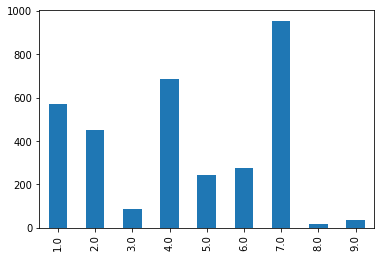

In [60]:
df['Class'].value_counts(sort=False).plot(kind='bar')

### 2. Обработка текстового признака

#### 2.1. Первичное преобразование текста

In [61]:
"""def preprocessing_text(text):
    #пунктуация
    PUNCT_TO_REMOVE = string.punctuation
    #стопслова английского языка
    STOPWORDS = set(stopwords.words('english'))
    #приводим к нижнему регистру
    text = text.lower()
    #удаляем пунктуацию
    text = text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))
    #удаляем стопслова
    text = ' '.join([word for word in str(text).split() if word not in STOPWORDS])
    #удаляем редкие слова
    cnt = Counter()
    n_rare_words = 10
    RAREWORDS = set([w for (w, wc) in cnt.most_common()[:-n_rare_words-1:-1]])
    text = " ".join([word for word in str(text).split() if word not in RAREWORDS])
    
    return text"""

'def preprocessing_text(text):\n    #пунктуация\n    PUNCT_TO_REMOVE = string.punctuation\n    #стопслова английского языка\n    STOPWORDS = set(stopwords.words(\'english\'))\n    #приводим к нижнему регистру\n    text = text.lower()\n    #удаляем пунктуацию\n    text = text.translate(str.maketrans(\'\', \'\', PUNCT_TO_REMOVE))\n    #удаляем стопслова\n    text = \' \'.join([word for word in str(text).split() if word not in STOPWORDS])\n    #удаляем редкие слова\n    cnt = Counter()\n    n_rare_words = 10\n    RAREWORDS = set([w for (w, wc) in cnt.most_common()[:-n_rare_words-1:-1]])\n    text = " ".join([word for word in str(text).split() if word not in RAREWORDS])\n    \n    return text'

In [62]:
def preprocessing_text(text):
    #пунктуация
    PUNCT_TO_REMOVE = string.punctuation
    #стопслова английского языка
    STOPWORDS = set(stopwords.words('english'))
    #приводим к нижнему регистру
    text = text.lower()
    #удаляем пунктуацию
    text = text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))
    #удаляем стопслова
    text = ' '.join([word for word in str(text).split() if word not in STOPWORDS])
    #удаляем редкие слова
    cnt = Counter()
    n_rare_words = 10
    RAREWORDS = set([w for (w, wc) in cnt.most_common()[:-n_rare_words-1:-1]])
    text = " ".join([word for word in str(text).split() if word not in RAREWORDS])
    
    #приводим слова к базовой форме с помощью стиматизации
    stemmer = PorterStemmer()
    text = " ".join([stemmer.stem(word) for word in text.split()])
    
    """lemmatizer = WordNetLemmatizer()
    wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
    pos_tagged_text = nltk.pos_tag(text.split())    
    text = " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])"""
    
    return text

In [63]:
%%time
df['clean_text'] = df['Text'].apply(lambda x: preprocessing_text(x))

CPU times: user 4min 9s, sys: 1.16 s, total: 4min 10s
Wall time: 4min 10s


In [64]:
df

,ID,Gene,Variation,Class,Text,clean_text
0,0,FAM58A,Truncating Mutations,1.0,Cyclin-dependent kinases (CDKs) regulate a var...,cyclindepend kinas cdk regul varieti fundament...
1,1,CBL,W802*,2.0,Abstract Background Non-small cell lung canc...,abstract background nonsmal cell lung cancer n...
2,2,CBL,Q249E,2.0,Abstract Background Non-small cell lung canc...,abstract background nonsmal cell lung cancer n...
3,3,CBL,N454D,3.0,Recent evidence has demonstrated that acquired...,recent evid demonstr acquir uniparent disomi a...
4,4,CBL,L399V,4.0,Oncogenic mutations in the monomeric Casitas B...,oncogen mutat monomer casita blineag lymphoma ...
...,...,...,...,...,...,...
4302,982,TP63,S580P,NaN,IκB kinase β (IKKβ) is involved in tumor devel...,iκb kinas β ikkβ involv tumor develop progress...
4303,983,SCN4A,R672G,NaN,he identification of subtype-specific transloc...,identif subtypespecif transloc revolution diag...
4304,984,BRAF,N581H,NaN,Cardio-facio-cutaneous (CFC) syndrome (MIM 115...,cardiofaciocutan cfc syndrom mim 115150 congen...
4305,985,TSHR,S281N,NaN,Screening for tumor suppressor genes in breast...,screen tumor suppressor gene breast cancer rev...


In [65]:
#функция для подсчета слова в тексте
def count_words(TEXT, Gene_Var):
    wordlist = TEXT.split(' ')
    cnt = 0
    for s in wordlist:
        if (Gene_Var==s):
            cnt+=1
    return cnt

In [66]:
df['Gene_cnt'] = df.apply(lambda x: count_words(x['Text'], x['Gene']), axis=1)
df['Variation_cnt'] = df.apply(lambda x: count_words(x['Text'], x['Variation']), axis=1)

#### 2.2. Векторизация текста

In [67]:
#векторизация текста
def vectorize_text(text, max_features=250, ngram_range=(1,2), min_df=1):
    X_vect = list(text)
    tfidf = TfidfVectorizer(min_df=min_df,
                            ngram_range=ngram_range,
                            max_features=max_features
                            )
    X_vect = pd.DataFrame(tfidf.fit_transform(X_vect).toarray(), index=text.index)
    return X_vect

In [68]:
with open('df.pickle', 'wb') as handle:
    pickle.dump(df, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [69]:
tfidf_features = vectorize_text(df['clean_text'])

In [70]:
tfidf_features

,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
0,0.079979,0.011966,0.021627,0.005289,0.016927,0.010995,0.036674,0.022516,0.005750,0.005705,...,0.000000,0.000000,0.025258,0.040784,0.015384,0.011237,0.027915,0.010824,0.016186,0.075998
1,0.071159,0.035071,0.018110,0.022146,0.014174,0.009207,0.017549,0.014141,0.004815,0.009555,...,0.000000,0.000000,0.037014,0.000000,0.017177,0.004705,0.009350,0.031722,0.004518,0.038184
2,0.071159,0.035071,0.018110,0.022146,0.014174,0.009207,0.017549,0.014141,0.004815,0.009555,...,0.000000,0.000000,0.037014,0.000000,0.017177,0.004705,0.009350,0.031722,0.004518,0.038184
3,0.093057,0.006188,0.016775,0.032823,0.029177,0.022742,0.021674,0.011644,0.005946,0.023602,...,0.020768,0.088655,0.006531,0.000000,0.031822,0.023243,0.040419,0.089553,0.011160,0.000000
4,0.045803,0.018274,0.008257,0.012117,0.030158,0.004198,0.016002,0.008596,0.004390,0.008713,...,0.030666,0.010070,0.019286,0.000000,0.003916,0.017161,0.004263,0.074382,0.016479,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4302,0.080188,0.005052,0.031955,0.040193,0.033347,0.018566,0.030964,0.004753,0.033981,0.038535,...,0.005651,0.005567,0.015994,0.024596,0.004330,0.009488,0.065993,0.022846,0.004555,0.000000
4303,0.060805,0.038530,0.019344,0.007570,0.008075,0.000000,0.011246,0.008056,0.008228,0.008164,...,0.043105,0.018873,0.027110,0.004169,0.011008,0.012061,0.003995,0.007745,0.023164,0.005438
4304,0.018825,0.010014,0.056560,0.033200,0.040137,0.043706,0.026307,0.011777,0.026465,0.023873,...,0.000000,0.000000,0.018496,0.002438,0.019312,0.014106,0.002336,0.013587,0.006773,0.000000
4305,0.014288,0.008551,0.030908,0.022678,0.024191,0.015713,0.007487,0.016089,0.016434,0.032613,...,0.000000,0.000000,0.036097,0.016653,0.021986,0.008030,0.015958,0.000000,0.015421,0.000000


#### 2.3. Декомпозиция текста

In [71]:
#уменьшаем размерность с помощью усеченного сингулярного разложения
svd = TruncatedSVD(n_components=50, #размерность выходных данных
                   n_iter=5, #количество итераций
                   random_state=42
                   )
truncated_tfidf = svd.fit_transform(tfidf_features)
df_tfidf_col_name = ['tdidf_' + str(i) for i in range(50)]
df_tfidf = pd.DataFrame(truncated_tfidf)
df_tfidf.columns = df_tfidf_col_name


#### 2.4. Мешок слов

In [72]:
count_vectorizer = CountVectorizer(min_df=1, ngram_range=(1,1))
count_features = count_vectorizer.fit_transform(df['clean_text'])
count_svd = TruncatedSVD(n_components=50, #размерность выходных данных
                   n_iter=5, #количество итераций
                   random_state=42
                   )
count_bow = count_svd.fit_transform(count_features)
df_bow_col_name = ['bow_' + str(i) for i in range(50)]
df_bow = pd.DataFrame(count_bow)
df_bow.columns = df_bow_col_name

#### 2.5. Кодирование признаков Gene и Variation

In [73]:
df = pd.get_dummies(df, columns=['Gene', 'Variation'], drop_first=True)

In [74]:
df.head()

,ID,Class,Text,clean_text,Gene_cnt,Variation_cnt,Gene_ABCC6,Gene_ABL1,Gene_ACVR1,Gene_ADAMTS13,...,Variation_YAP1-TFE3 Fusion,Variation_YWHAE-ROS1 Fusion,Variation_ZC3H7B-BCOR Fusion,Variation_ZNF198-FGFR1 Fusion,Variation_null1313Y,Variation_null189Y,Variation_null262Q,Variation_null267R,Variation_null399R,Variation_p61BRAF
0,0,1.0,Cyclin-dependent kinases (CDKs) regulate a var...,cyclindepend kinas cdk regul varieti fundament...,30,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,2.0,Abstract Background Non-small cell lung canc...,abstract background nonsmal cell lung cancer n...,5,10,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,2.0,Abstract Background Non-small cell lung canc...,abstract background nonsmal cell lung cancer n...,5,8,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,3.0,Recent evidence has demonstrated that acquired...,recent evid demonstr acquir uniparent disomi a...,95,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,4.0,Oncogenic mutations in the monomeric Casitas B...,oncogen mutat monomer casita blineag lymphoma ...,110,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### 2.6. Перобразование перед обучением

In [75]:
#соединием все таблицы в одну
df = df.join(df_tfidf)
df = df.join(df_bow)

In [76]:
df.shape

(4307, 4426)

In [77]:
df_train = df.iloc[:train_df.shape[0]]
X = df_train.iloc[:,4:]
y = df_train['Class']

df_test = df.iloc[train_df.shape[0]:]
X_test = df_test.iloc[:,4:]

In [78]:
X_train = X.copy()
y_train = y.copy()

### 3. Обучение модели

In [79]:
#распознавание классов с 0, вычитаем 1. После обучения прибавим к предикту
y_train = y_train - 1

В качестве модели обучения используем XGBoost

In [80]:
#задаём парамметры модели
xgb_param = {'objective': 'multi:softprob',
             'eval_metric': 'mlogloss',
             'learning_rate': 0.05,
             'max_depth': 5,
             'num_class': 9,
             'ntread': 4,
             'seed': 10
             }

dtrain_xgb = xgb.DMatrix(X_train, label=y_train)

xgb_result = xgb.cv(xgb_param,
                    dtrain_xgb,
                    num_boost_round=300,
                    nfold=3,
                    stratified=True,
                    early_stopping_rounds=50,
                    verbose_eval=100,
                    show_stdv=True
                    )

[20:11:47] WARNING: ../src/learner.cc:767: 
Parameters: { "ntread" } are not used.

[20:11:47] WARNING: ../src/learner.cc:767: 
Parameters: { "ntread" } are not used.

[20:11:48] WARNING: ../src/learner.cc:767: 
Parameters: { "ntread" } are not used.

[0]	train-mlogloss:2.11088+0.00191	test-mlogloss:2.12492+0.00266
[100]	train-mlogloss:0.50949+0.01403	test-mlogloss:0.99686+0.03396
[200]	train-mlogloss:0.32004+0.01042	test-mlogloss:0.97020+0.04273
[224]	train-mlogloss:0.29466+0.00865	test-mlogloss:0.97394+0.04268


In [81]:
#лучший номер раунда
best_round = len(xgb_result['test-mlogloss-mean'])
print('Лучший номер раунда = ' + str(best_round))

Лучший номер раунда = 176


In [82]:
#итоговая модель
xgb_cl = xgb.train(xgb_param,
                   dtrain_xgb,
                   num_boost_round=best_round)

[20:15:48] WARNING: ../src/learner.cc:767: 
Parameters: { "ntread" } are not used.



In [83]:
xgb_test = xgb.DMatrix(X_test)

In [84]:
y_pred = xgb_cl.predict(xgb_test)

In [85]:
classes = ['class1', 'class2', 'class3', 'class4','class5', 'class6', 'class7', 'class8','class9']
submit = pd.DataFrame(y_pred, columns=classes)
submit['ID'] = test_df['ID'].values

In [86]:
submit = submit[['ID', 'class1', 'class2', 'class3', 'class4','class5', 'class6', 'class7', 'class8','class9']]

In [87]:
submit

,ID,class1,class2,class3,class4,class5,class6,class7,class8,class9
0,1,0.381672,0.070640,0.018702,0.272869,0.111284,0.100012,0.038796,0.003030,0.002995
1,2,0.795033,0.037442,0.003375,0.037997,0.028023,0.008861,0.087218,0.000808,0.001244
2,3,0.273649,0.226393,0.006325,0.206553,0.033672,0.067235,0.181109,0.002591,0.002472
3,4,0.133410,0.177599,0.004208,0.208564,0.023042,0.042170,0.405179,0.002441,0.003388
4,5,0.020443,0.161176,0.008709,0.021352,0.032348,0.080214,0.672404,0.001651,0.001703
...,...,...,...,...,...,...,...,...,...,...
981,982,0.146695,0.124295,0.006644,0.210923,0.020737,0.064695,0.421753,0.002166,0.002093
982,983,0.023832,0.231462,0.001515,0.038725,0.010165,0.010546,0.672089,0.007816,0.003850
983,984,0.021348,0.234873,0.003998,0.024870,0.016212,0.056195,0.638518,0.001983,0.002004
984,985,0.099892,0.099743,0.003419,0.150815,0.026823,0.025344,0.588398,0.002823,0.002743
